Let's improve velocity predictions.

In [22]:
import pandas as pd
import datetime

stories = pd.read_csv('data/bosh_stories.csv')

stories['created_at'] = pd.to_datetime(stories['created_at'])
stories['accepted_at'] = pd.to_datetime(stories['accepted_at'])
stories['updated_at'] = pd.to_datetime(stories['updated_at'])

stories.sort('created_at', inplace=True)
stories['estimate'].fillna(0, inplace=True)
stories_without_nans = stories.dropna(subset=['accepted_at'])

# Calculate week buckets
def get_week_num_from_date(date):
    first_date = stories['created_at'].head(1).values[0]
    days_since_start = date - first_date
    week_since_start = days_since_start / datetime.timedelta(days=7)
    return math.floor(week_since_start)

import math
stories_without_nans['accepted_at_week'] = stories_without_nans['accepted_at'].apply(get_week_num_from_date)
stories_without_nans['created_at_week'] = stories_without_nans['created_at'].apply(get_week_num_from_date)

story_type_counts_by_created_week = stories_without_nans.groupby(['created_at_week','story_type']).count()['id']

week_data = story_type_counts_by_created_week.unstack().fillna(0)

velocity_by_week = stories_without_nans.groupby(['accepted_at_week']).sum()['estimate']
week_data['points'] = velocity_by_week
week_data.fillna(0, inplace=True)

/home/sam/.virtualenvs/velocity/lib/python3.4/site-packages/ipykernel/__main__.py:10: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/home/sam/.virtualenvs/velocity/lib/python3.4/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/sam/.virtualenvs/velocity/lib/python3.4/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [23]:
import json
import ast

def make_row(iteration_row):
    stories = ast.literal_eval(iteration_row.stories)
    for s in stories:
        s['iteration'] = iteration_row.number
        s['team_strength'] = iteration_row.team_strength
    
    return stories

iteration_df = pd.read_csv('data/bosh_iterations.csv')

iterations = iteration_df.apply(make_row, 1).values
all_stories = []
for iteration in iterations:
    all_stories.extend(iteration)

In [24]:
story_df = pd.DataFrame(all_stories)
story_df.estimate.fillna(0, inplace=True)
story_df.head()

,accepted_at,created_at,current_state,deadline,description,estimate,id,iteration,kind,labels,name,owned_by_id,owner_ids,project_id,requested_by_id,story_type,team_strength,updated_at,url
0,2013-11-15T18:41:07Z,2013-10-16T20:57:37Z,accepted,NaN,follow-on from #56532652\n\nthe new box is rea...,0,59004602,1,story,"[{'updated_at': '2013-11-14T20:34:18Z', 'kind'...",roll the 'old' prod jumpbox to the new instance,756869,[756869],956238,1338772,chore,0.3,2013-11-15T18:41:22Z,https://www.pivotaltracker.com/story/show/5900...
1,2013-11-15T21:35:47Z,2013-10-24T22:02:23Z,accepted,NaN,ci build was aborted and didnt have a chance t...,0,59523646,1,story,"[{'updated_at': '2013-11-14T20:34:18Z', 'kind'...",vsphere microbosh bats should clean up before ...,1068489,[1068489],956238,81882,chore,0.3,2013-11-15T21:35:48Z,https://www.pivotaltracker.com/story/show/5952...
2,2013-11-15T21:36:01Z,2013-10-29T19:00:55Z,accepted,NaN,NaN,0,59778912,1,story,"[{'updated_at': '2013-11-14T20:34:18Z', 'kind'...",Rebuild Jumpboxes in A1 & Prod,756869,[756869],956238,81882,chore,0.3,2013-11-15T21:36:03Z,https://www.pivotaltracker.com/story/show/5977...
3,2013-11-19T21:45:03Z,2013-11-19T01:45:09Z,accepted,NaN,Automation creates a release and uploads it. S...,0,61008990,2,story,[],Investigate AWS bosh partial release upload,1068489,[1068489],956238,1068489,chore,1.0,2013-11-19T21:45:15Z,https://www.pivotaltracker.com/story/show/6100...
4,2013-11-20T07:23:56Z,2013-11-19T04:57:12Z,accepted,NaN,see details: https://groups.google.com/a/cloud...,0,61014318,2,story,[],review and advise on bosh director template er...,1068489,[1068489],956238,494053,feature,1.0,2013-11-20T07:23:56Z,https://www.pivotaltracker.com/story/show/6101...


In [25]:
def count_unique_users(weekly_users):
    return len(set(weekly_users))

In [26]:
special_iteration_df = pd.read_csv('data/bosh_special_iterations.csv')
special_iteration_df.head()

,accepted,analytics,effective_points,length,number,points,story_ids,team_strength,velocity
0,"{'header': ['date', 'story_type', 'points_acce...","{'cycle_time': 0, 'stories_accepted': 3, 'reje...",0.000000,1,1,0,"[59004602, 59523646, 59778912]",0.30,10
1,"{'header': ['date', 'story_type', 'points_acce...","{'cycle_time': 0, 'stories_accepted': 13, 'rej...",13.000000,1,2,13,"[61008990, 61014318, 60955736, 60125634, 60860...",1.00,10
2,"{'header': ['date', 'story_type', 'points_acce...","{'cycle_time': 0, 'stories_accepted': 5, 'reje...",5.000000,1,3,2,"[57964476, 61162324, 61568252, 61074790, 61084...",0.40,10
3,"{'header': ['date', 'story_type', 'points_acce...","{'cycle_time': 0, 'stories_accepted': 15, 'rej...",11.250000,1,4,9,"[61412354, 61179184, 61857938, 61843830, 61179...",0.80,6
4,"{'header': ['date', 'story_type', 'points_acce...","{'cycle_time': 0, 'stories_accepted': 19, 'rej...",15.294118,1,5,13,"[62001564, 62208014, 62258414, 62202440, 61708...",0.85,9


In [27]:
special_iteration_df.analytics[0]

analytics_df = pd.DataFrame(list(special_iteration_df.analytics.apply(ast.literal_eval).values))
analytics_df['iteration'] = special_iteration_df.number
analytics_df.head()

,bugs_created,cycle_time,kind,rejection_rate,stories_accepted,iteration
0,2,0,analytics,0,3,1
1,4,0,analytics,0,13,2
2,2,0,analytics,0,5,3
3,5,0,analytics,0,15,4
4,7,0,analytics,0,19,5


In [28]:
WEEK_LAG = 10

week_group = story_df.groupby('iteration')
week_data = week_group.agg({'estimate': sum, 'team_strength': 'first'})
week_data.rename(columns={'estimate': 'total_points'}, inplace=True)
week_data['contributors'] = week_group.owner_ids.sum().apply(count_unique_users)

# Effective points is given as a beta feature from the iteration API
week_data['effective_points'] = week_data['total_points'] / week_data['team_strength']
#week_data['effective_points'] = special_iteration_df['effective_points']
week_data['effective_std'] = pd.rolling_std(week_data['effective_points'], WEEK_LAG).shift(1)
week_data['effective_mean'] = pd.rolling_mean(week_data['effective_points'], WEEK_LAG).shift(1)
week_data['effective_mean']
week_data['volatility'] = week_data['effective_std'] / week_data['effective_mean'] * 100


In [29]:
weeks = week_data.merge(analytics_df, right_on='iteration', left_index='iteration')
weeks['misprediction_margin'] = abs(weeks.effective_points - weeks.effective_mean)
weeks['stds_outside_volatile_range'] = weeks['misprediction_margin'] / weeks.effective_std
weeks.head()

,team_strength,total_points,contributors,effective_points,effective_std,effective_mean,volatility,bugs_created,cycle_time,kind,rejection_rate,stories_accepted,iteration,misprediction_margin,stds_outside_volatile_range
0,0.30,0,2,0.000000,NaN,NaN,NaN,2,0,analytics,0,3,1,NaN,NaN
1,1.00,13,7,13.000000,NaN,NaN,NaN,4,0,analytics,0,13,2,NaN,NaN
2,0.40,2,3,5.000000,NaN,NaN,NaN,2,0,analytics,0,5,3,NaN,NaN
3,0.80,9,6,11.250000,NaN,NaN,NaN,5,0,analytics,0,15,4,NaN,NaN
4,0.85,13,8,15.294118,NaN,NaN,NaN,7,0,analytics,0,19,5,NaN,NaN


The difference between the velocity and the week's effective points is the misprediction margin.

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

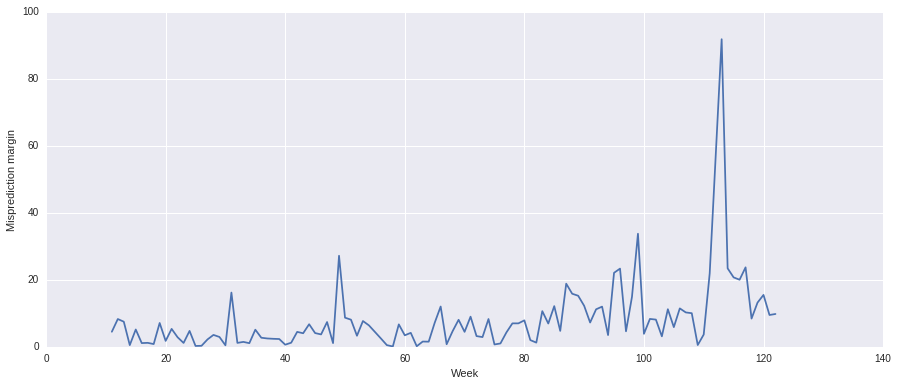

In [31]:
plt.figure(figsize=(15,6))
plt.plot(weeks.iteration, weeks.misprediction_margin)
plt.xlabel('Week')
plt.ylabel('Misprediction margin')

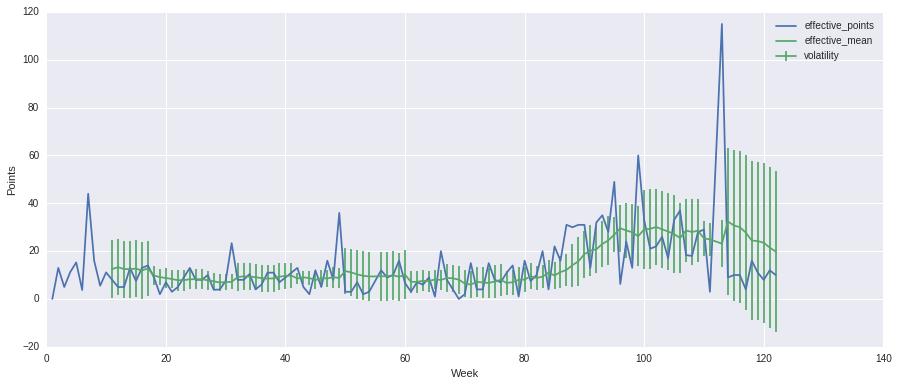

In [32]:
plt.figure(figsize=(15,6))
plt.plot(weeks.iteration, weeks.effective_points, label='effective_points')
plt.errorbar(weeks.iteration, weeks.effective_mean, yerr=weeks.effective_std, label='volatility')
plt.legend()
plt.xlabel('Week')
plt.ylabel('Points')

Normalizing the misprediction margin by the volatility (or more specifically, the rolling standard error) yields how effectively the combination of velocity and volatility managed to forecast the team's actual performance on the following week.

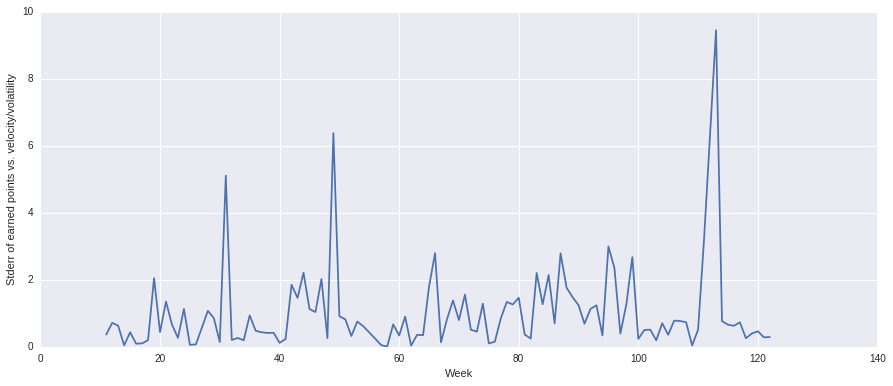

In [33]:
plt.figure(figsize=(15,6))
plt.plot(weeks.iteration, weeks.stds_outside_volatile_range)
plt.xlabel('Week')
plt.ylabel('Stderr of earned points vs. velocity/volatility')

The 

In [39]:
weeks.stds_outside_volatile_range.describe()

count    110.000000
mean       0.993944
std        1.273929
min        0.009780
25%        0.299096
50%        0.660412
75%        1.258699
max        9.455227
Name: stds_outside_volatile_range, dtype: float64

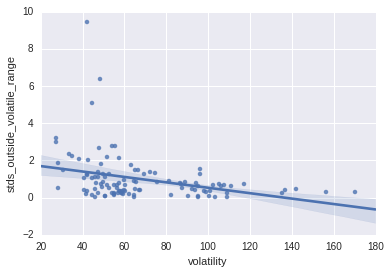

In [34]:
# Relationship between volatility and the normalized misprediction margin
sns.regplot(weeks.volatility, weeks.stds_outside_volatile_range)


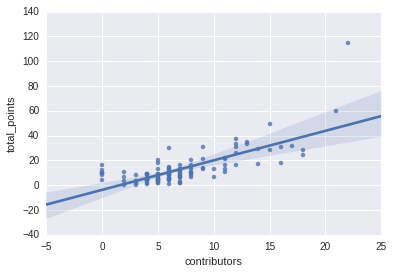

In [35]:
# Relationship between contributors and total points?
sns.regplot(weeks.contributors, weeks.total_points)

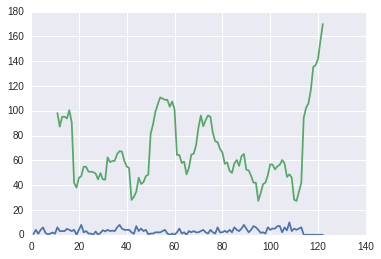

In [36]:
### I want this to ask questions about lag effects that bugs_created has on volatility.

plt.plot(weeks.iteration, weeks.bugs_created * weeks.team_strength)
plt.plot(weeks.iteration, weeks.volatility)

In [37]:
import statsmodels as sm
